# Loan Recommendation System
## POC - Proof Of Concept

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [2]:
# from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import Normalizer
# from pyspark.sql.functions import mean
# from pyspark.sql.window import Window
# from pyspark.ml import Pipeline 

In [3]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "2g").getOrCreate()

In [4]:
spark

In [5]:
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



- Id: Likely a unique identifier for each data point.
- AccountID: Unique identifier for an account (possibly borrower).
- <h4>Loan-related features: </h4> 
    -> Number_Of_Loans_Granted__c: Number of loans granted to the account.
    -> Num_Of_Loans_Paid__c: Number of loans paid by the account.
    -> Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    -> Total_Repayments__c: Total amount repaid by the account.
    -> Amount: Loan amount requested.
    -> Term_in_Weeks__c: Loan term in weeks.
    -> Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
- <h4>Borrower-related features: </h4>    -> 
StageName: Current stage of the loan application (e.g., application, approved, rejected).    -> 
Applicant Age: Age of the loan applicant    -> .
summary_income: Summary of applicant's incom    -> e.
summary_income_cv: Coefficient of variation of applicant's inco- <h4>me.
Location-related feat </h4>u    -> res:
city: City of the appli    -> cant.
state: State of the appl    -> icant.
Country: Country of the ap

- <h4>Additional features:</h4>    -> 
userId: Unique identifier for a user Account Id in Numericr).    -> 
loanId: Unique identifier for a lo (Id or loanId in Numeric)an    -> .
counFeature related to the Ratings of the Loansnt    -> s.
LoanIdFormat: Format of the loan(Created LoanId using Clusters)nce).plicant.

In [6]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|   500|                 10|              Weekly|    3|
|           1|   700|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   900|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



### Aggregating the loans per user (getting all loans for each user user)

In [7]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("LoanIdFormat").alias("loans"))

In [8]:
user_loans.select("userId","loans").show(10,truncate=False)

+------+-----------------+
|userId|loans            |
+------+-----------------+
|1     |[12, 1, 2, 11, 8]|
|2     |[1, 2, 6]        |
|3     |[6, 7]           |
|4     |[6]              |
|5     |[1, 6]           |
|6     |[1, 6]           |
|7     |[1, 2, 6]        |
|8     |[1, 2]           |
|9     |[6]              |
|10    |[1, 2, 6]        |
+------+-----------------+
only showing top 10 rows



In [9]:
lopo = user_loans.toPandas()

In [10]:
lopo.head()

,userId,loans
0,1,"[12, 1, 2, 11, 8]"
1,2,"[1, 2, 6]"
2,3,"[6, 7]"
3,4,[6]
4,5,"[1, 6]"


In [11]:
dict_lopo = lopo.to_dict('records')

In [12]:
dict_lopo

[{'userId': 1, 'loans': [12, 1, 2, 11, 8]},
 {'userId': 2, 'loans': [1, 2, 6]},
 {'userId': 3, 'loans': [6, 7]},
 {'userId': 4, 'loans': [6]},
 {'userId': 5, 'loans': [1, 6]},
 {'userId': 6, 'loans': [1, 6]},
 {'userId': 7, 'loans': [1, 2, 6]},
 {'userId': 8, 'loans': [1, 2]},
 {'userId': 9, 'loans': [6]},
 {'userId': 10, 'loans': [1, 2, 6]},
 {'userId': 11, 'loans': [1, 2, 6]},
 {'userId': 12, 'loans': [1, 6, 7]},
 {'userId': 13, 'loans': [1, 6, 4]},
 {'userId': 14, 'loans': [1, 2, 6]},
 {'userId': 15, 'loans': [1, 2]},
 {'userId': 16, 'loans': [1, 6, 7]},
 {'userId': 17, 'loans': [1, 2]},
 {'userId': 18, 'loans': [1, 6]},
 {'userId': 19, 'loans': [1, 6, 7]},
 {'userId': 20, 'loans': [6]},
 {'userId': 21, 'loans': [1, 13, 2, 6, 7]},
 {'userId': 22, 'loans': [1, 6]},
 {'userId': 23, 'loans': [6]},
 {'userId': 24, 'loans': [1, 6]},
 {'userId': 25, 'loans': [1, 2, 6]},
 {'userId': 26, 'loans': [1, 2, 6]},
 {'userId': 27, 'loans': [1, 6]},
 {'userId': 28, 'loans': [1]},
 {'userId': 29, 'l

In [13]:
loans_df.select(["userId","LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|      LoanIdFormat|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            559151|            559151|            559151|           559151|             559151|                    559151|              559151|
|   mean|24735.774815747445| 4.527168868516734|1.6699120631099649|823.7755990778877| 7.0393507299459355|        11.901447015206983|   11.85676856519974|
| stddev|15283.929730968575|2.7984778294163046|0.8954014280676444|766.2637755312196| 3.9631196080149786|         8.154409123854771|   8.273339043377455|
|    min|                 1|                 1|                 0|              10

In [14]:
loans_df.show(vertical=True)

-RECORD 0------------------------------------------
 Id                         | 0062x00000DsEQcAAN   
 AccountID                  | 0010K00001ayVHPQA2   
 Number_Of_Loans_Granted__c | 27                   
 Num_Of_Loans_Paid__c       | 27                   
 Purpose_of_Loan__c         | Furniture or Appl... 
 Total_Repayments__c        | 10                   
 Amount                     | 500                  
 Term_in_Weeks__c           | 10.143               
 Payment_Frequency__c       | Weekly               
 StageName                  | Loan Paid            
 Applicant Age              | 55                   
 summary_income             | 2166.67              
 summary_income_cv          | 5750.7               
 city                       | Jimboomba            
 state                      | QLD                  
 Country                    | Australia            
 userId                     | 1                    
 loanId                     | 385865               
 count      

In [15]:
hist_data  = loans_df.toPandas()

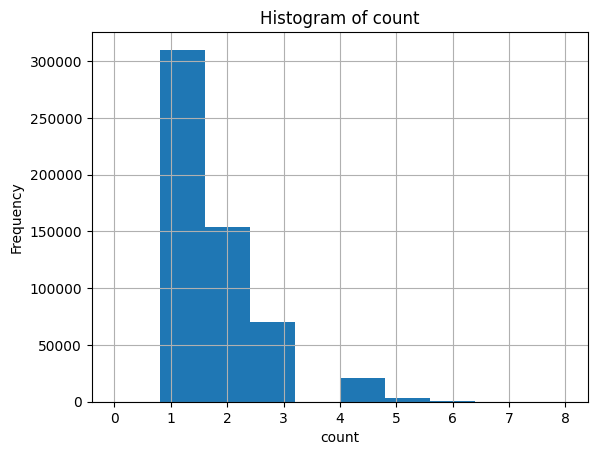

In [16]:
hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

In [17]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 20
Number of unique Loan Id: 407389


In [18]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

# Count the number of unique users
# tmp = ratings_df.select('movieId').distinct().count()
# print(f"Number of unique movies: {tmp}")

Number of unique users: 59158


In [19]:
print('Distinct values of count:')
print(sorted(loans_df.select('count').distinct().collect()))

Distinct values of count:
[Row(count=0), Row(count=1), Row(count=2), Row(count=3), Row(count=4), Row(count=5), Row(count=6), Row(count=7), Row(count=8)]


In [20]:
# distinct values of the rating
loans_df.select("count").distinct().show()

+-----+
|count|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    8|
|    7|
|    2|
|    0|
+-----+



========================================================================================================

Converting the dataset into train test and validation split.

In [21]:
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    3|   500|
|           1|    3|   700|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   900|
|           1|    3|  1000|
|           1|    3|  1000|
+------------+-----+------+
only showing top 10 rows



In [22]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [23]:
validation.select(["userId","loanId","LoanIdFormat","count","Amount","Total_Repayments__c"]).show()

+------+------+------------+-----+------+-------------------+
|userId|loanId|LoanIdFormat|count|Amount|Total_Repayments__c|
+------+------+------------+-----+------+-------------------+
|   165|    54|           1|    1|   500|                 10|
|   186|    99|           1|    1|   350|                 10|
| 24654|   167|           1|    3|   550|                 10|
| 24654|   167|           1|    3|   550|                 10|
| 24289|   184|           1|    2|   200|                 10|
| 25245|   190|           1|    1|   850|                 10|
| 24831|   252|           1|    1|  1000|                 10|
| 39421|   261|           1|    1|  1000|                 10|
| 23540|   284|           1|    2|   500|                 10|
|   189|   334|           1|    1|   500|                 10|
| 23790|   340|           1|    1|   550|                 10|
| 23440|   416|           1|    2|   250|                 10|
| 23505|   435|           1|    3|   600|                 10|
| 23330|

In [24]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [25]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)
            
            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))
            
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [29]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.04087784201150596
8 latent factors and regularization = 0.01: validation RMSE is 0.03655448027989346
8 latent factors and regularization = 0.05: validation RMSE is 0.08599227146846665
8 latent factors and regularization = 0.1: validation RMSE is 0.10522232145306834
8 latent factors and regularization = 0.2: validation RMSE is 0.1982251111395023
10 latent factors and regularization = 0.001: validation RMSE is 0.01853803722084138
10 latent factors and regularization = 0.01: validation RMSE is 0.0437923945346567
10 latent factors and regularization = 0.05: validation RMSE is 0.04132197650726964
10 latent factors and regularization = 0.1: validation RMSE is 0.0858864736076378
10 latent factors and regularization = 0.2: validation RMSE is 0.20302601544981602
20 latent factors and regularization = 0.001: validation RMSE is 0.10122084718956963
20 latent factors and regularization = 0.01: validation RMSE is 0.03838081751886617
2

In [30]:
#OLD :  40 latent factors and regularization = 0.001
#NEW: The best model has 8 latent factors and regularization = 0.001

In [36]:
model_path = "Als_model.pkl"

final_model.save(model_path)

Py4JJavaError: An error occurred while calling o3202.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1620)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1620)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1606)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1606)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.recommendation.ALSModel$ALSModelWriter.saveImpl(ALS.scala:549)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 51 more


## Predicting the results from validation data

In [31]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [32]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "LoanIdFormat", "prediction").show(20)

+------+------+-----+------------+----------+
|userId|loanId|count|LoanIdFormat|prediction|
+------+------+-----+------------+----------+
|    10| 24267|    4|           1| 3.9895122|
|    10| 53184|    4|           1| 3.9895122|
|    10| 68823|    4|           1| 3.9895122|
|    10| 15451|    4|           6| 4.0013065|
|    10| 17247|    4|           6| 4.0013065|
|    10| 19052|    4|           6| 4.0013065|
|    10| 23209|    4|           6| 4.0013065|
+------+------+-----+------------+----------+



In [33]:
predictions.count()

112045

In [34]:
validation.count()

112553

In [35]:
# Count the number of unique items
tmp = validation.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 43799


## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [31]:
 
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))


Root Mean Squared Error (RMSE) = 0.019887318161846548


## Recommendation of N users

In [32]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [33]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [34]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



## ALS Model Evaluation

In [35]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'LoanIdFormat'], 'inner')

In [36]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(LoanIdFormat) as true_positives'))

In [37]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(LoanIdFormat) as relevant'))

In [38]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [39]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [40]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [41]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [42]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.8443695205505766
Overall Recall: 1.8443695205505766
Overall F1-score: 1.8443695205505894


## User Factors and Item Factors to calculate the cosine Similarity

In [43]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [44]:
userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [45]:
userFactors.select("id","features").sort("id").show(10,truncate=False)

+---+--------------------------------------------------------------------------------+
|id |features                                                                        |
+---+--------------------------------------------------------------------------------+
|1  |[0.079454556, 2.1407895, 0.0, 5.7823067, 2.402481, 3.0774658, 3.0254288, 0.0]   |
|2  |[0.020951016, 1.4521546, 0.0, 3.8342512, 1.6102232, 2.0741513, 2.0110178, 0.0]  |
|3  |[0.0030623926, 0.696911, 0.0, 1.9020239, 0.821006, 1.0624447, 1.0137556, 0.0]   |
|4  |[0.0, 0.7084668, 0.0, 1.9032042, 0.8179459, 1.0627179, 1.0060762, 0.0]          |
|5  |[0.0013885743, 1.4231364, 0.0, 3.8088698, 1.6329477, 2.1198778, 2.0119267, 0.0] |
|6  |[0.0, 0.7084668, 0.0, 1.9032042, 0.8179459, 1.0627179, 1.0060762, 0.0]          |
|7  |[0.0060389033, 0.71563435, 0.0, 1.9109018, 0.8115923, 1.0497216, 1.0059505, 0.0]|
|8  |[0.038340677, 1.4417765, 0.0, 3.8513973, 1.6018468, 2.0539732, 2.0118163, 0.0]  |
|9  |[0.0, 0.7084668, 0.0, 1.9032042, 0.817

In [46]:
itemFactors.select("id","features").sort("id").show(10,truncate=False)

+---+--------------------------------------------------------------------------------------+
|id |features                                                                              |
+---+--------------------------------------------------------------------------------------+
|1  |[7.6533196E-4, 0.10480316, 0.0, 0.27371284, 0.11542864, 0.14901587, 0.14384918, 0.0]  |
|2  |[0.004521174, 0.10176462, 0.0, 0.27745017, 0.11396965, 0.14523378, 0.14414558, 0.0]   |
|3  |[0.027620958, 0.08650556, 0.0, 0.30859202, 0.10086614, 0.09982545, 0.15084302, 0.0]   |
|4  |[0.0017326659, 0.10636157, 0.0, 0.27439758, 0.1135298, 0.14782497, 0.14400436, 0.0]   |
|5  |[0.0026986524, 0.106670074, 0.0, 0.27420977, 0.114742056, 0.14709616, 0.14390172, 0.0]|
|6  |[0.0, 0.10144904, 0.0, 0.2725297, 0.11712592, 0.1521761, 0.14406528, 0.0]             |
|7  |[0.0015753818, 0.09554481, 0.0, 0.27203113, 0.11874679, 0.15209617, 0.14807315, 0.0]  |
|8  |[0.008617145, 0.09688087, 0.0, 0.28192648, 0.113441795, 0.1418250

In [47]:
import math

In [48]:
ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8 = [2.4307725, 7.9098544, 1.2765553, 0.024636148, 2.5557365, 3.767766, 0.072329044, 0.43128264]
ir1,ir2,ir3,ir4,ir5,ir6,ir7,ir8 = [0.10816363, 0.34584498, 0.053393964, 8.7923976E-4, 0.10868017, 0.16457365, 0.004021759, 0.024006216]
cosineSimily = ur1*ir1 +ur2*ir2 +ur3*ir3 +ur4*ir4 +ur5*ir5 +ur6*ir6 +ur7*ir7 +ur8*ir8
usernorm = math.sqrt(ur1**2 +ur2**2 +ur3**2 +ur4**2 +ur5**2 +ur6**2 +ur7**2 +ur8**2)
itemnorm = math.sqrt(ir1**2 +ir2**2 +ir3**2 +ir4**2 +ir5**2 +ir6**2 +ir7**2 +ir8**2)

print("Recommendation ::",cosineSimily/(usernorm*itemnorm))

Recommendation :: 0.9998678962582557


In [49]:
ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8 = [2.4307725, 7.9098544, 1.2765553, 0.024636148, 2.5557365, 3.767766, 0.072329044, 0.43128264]
ir1,ir2,ir3,ir4,ir5,ir6,ir7,ir8 = [0.112612374, 0.34390146, 0.03790004, 0.008411241, 0.09243223, 0.17332187, 0.008417915, 0.044041876]
cosineSimily = ur1*ir1 +ur2*ir2 +ur3*ir3 +ur4*ir4 +ur5*ir5 +ur6*ir6 +ur7*ir7 +ur8*ir8
usernorm = math.sqrt(ur1**2 +ur2**2 +ur3**2 +ur4**2 +ur5**2 +ur6**2 +ur7**2 +ur8**2)
itemnorm = math.sqrt(ir1**2 +ir2**2 +ir3**2 +ir4**2 +ir5**2 +ir6**2 +ir7**2 +ir8**2)

print("Recommendation ::",cosineSimily/(usernorm*itemnorm))


Recommendation :: 0.9956036270170981


In [50]:
final_model.userFactors.orderBy("id").collect()

[Row(id=1, features=[0.07945455610752106, 2.14078950881958, 0.0, 5.782306671142578, 2.4024810791015625, 3.077465772628784, 3.0254287719726562, 0.0]),
 Row(id=2, features=[0.02095101587474346, 1.4521546363830566, 0.0, 3.8342511653900146, 1.6102231740951538, 2.0741512775421143, 2.0110177993774414, 0.0]),
 Row(id=3, features=[0.003062392584979534, 0.6969109773635864, 0.0, 1.9020239114761353, 0.8210060000419617, 1.0624446868896484, 1.0137555599212646, 0.0]),
 Row(id=4, features=[0.0, 0.7084668278694153, 0.0, 1.9032042026519775, 0.8179458975791931, 1.0627179145812988, 1.0060762166976929, 0.0]),
 Row(id=5, features=[0.0013885742519050837, 1.4231363534927368, 0.0, 3.8088698387145996, 1.6329476833343506, 2.119877815246582, 2.0119266510009766, 0.0]),
 Row(id=6, features=[0.0, 0.7084668278694153, 0.0, 1.9032042026519775, 0.8179458975791931, 1.0627179145812988, 1.0060762166976929, 0.0]),
 Row(id=7, features=[0.006038903258740902, 0.7156343460083008, 0.0, 1.9109017848968506, 0.8115922808647156, 1.

In [51]:
type(userFactors)

pyspark.sql.dataframe.DataFrame

In [52]:
userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [53]:
userFactors.select(["id","Features"]).show(10,truncate=False)

+---+--------------------------------------------------------------------------------+
|id |Features                                                                        |
+---+--------------------------------------------------------------------------------+
|10 |[0.013504934, 2.8767014, 0.0, 7.633945, 3.248755, 4.206558, 4.0227757, 0.0]     |
|30 |[0.0, 0.7084668, 0.0, 1.9032042, 0.8179459, 1.0627179, 1.0060762, 0.0]          |
|40 |[0.0, 0.7084668, 0.0, 1.9032042, 0.8179459, 1.0627179, 1.0060762, 0.0]          |
|50 |[0.0040527894, 0.70465857, 0.0, 1.9046787, 0.8176661, 1.0569255, 1.0125383, 0.0]|
|60 |[0.001527321, 0.7152859, 0.0, 1.9059025, 0.81470364, 1.0565995, 1.0058231, 0.0] |
|70 |[0.0, 0.7084668, 0.0, 1.9032042, 0.8179459, 1.0627179, 1.0060762, 0.0]          |
|80 |[0.011263419, 1.4514643, 0.0, 3.8237002, 1.6169875, 2.08903, 2.010843, 0.0]     |
|90 |[0.0023248685, 0.7062724, 0.0, 1.9040542, 0.81779337, 1.0594053, 1.0097913, 0.0]|
|100|[0.0077211075, 0.6792483, 0.0, 1.90000

## Calculate cosine similarity:

### user-User Cosine Similarity code 

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [54]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [55]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


IndexError: list index out of range

### User-Item Cosine Similarity code

In [58]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 10 and 1: 0.9885118968777364


###  Cosine Similarity of user 10 with all Loans

In [59]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
    
    
    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [60]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 6, 'CosineSimilarity': 0.9996009535154022},
 {'userID': 10, 'LoanId': 7, 'CosineSimilarity': 0.9959666816778694},
 {'userID': 10, 'LoanId': 18, 'CosineSimilarity': 0.9909162020354028},
 {'userID': 10, 'LoanId': 20, 'CosineSimilarity': 0.989666344510677},
 {'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.9894651838450185},
 {'userID': 10, 'LoanId': 2, 'CosineSimilarity': 0.9892655607675901},
 {'userID': 10, 'LoanId': 14, 'CosineSimilarity': 0.9890152514470669},
 {'userID': 10, 'LoanId': 1, 'CosineSimilarity': 0.9885118968777364},
 {'userID': 10, 'LoanId': 4, 'CosineSimilarity': 0.9884166647157561},
 {'userID': 10, 'LoanId': 12, 'CosineSimilarity': 0.9839936033871914},
 {'userID': 10, 'LoanId': 15, 'CosineSimilarity': 0.9812189927250113},
 {'userID': 10, 'LoanId': 19, 'CosineSimilarity': 0.9669743421446426},
 {'userID': 10, 'LoanId': 5, 'CosineSimilarity': 0.9352839072434314},
 {'userID': 10, 'LoanId': 17, 'CosineSimilarity': 0.8132867667382443},
 {'userID': 10

### Cosine Similarity of first 10 users with all loans

In [61]:
# Cosine Similarity 
CosineSilty_first10 = []
starttime = time.time()
Nusers = 250
for userId in range(1,Nusers):
    TopCosineLoanforuser10 = []
    for item in range(itemFactors.count()):
        item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
        user1_id = userId
        user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
        item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
        
        
        user_item_similarity = cosine_similarity(user_factors, item_factors)
        TopCosineLoanforuser10.append({ item_id:user_item_similarity})
    Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
    CosineSilty_first10.append({"UserId":userId,"Recommendation":Recomnd_loans})
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} is : {runtime_hours}")

IndexError: list index out of range

In [5]:
# Sample data
data = [(0,), (1,), (2,), (3,)]
df = spark.createDataFrame(data, ["id"])

In [6]:
# Add 119 to the "id" column to create a new column called "id_plus_119"
df_with_new_column = df.withColumn("id_plus_119", col("id") + 119)

In [7]:
# Show the DataFrame with the new column
df_with_new_column.collect()

Py4JJavaError: An error occurred while calling o50.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 0.0 failed 1 times, most recent failure: Lost task 3.0 in stage 0.0 (TID 3) (MR-23 executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.EOFException
	at java.io.DataInputStream.readInt(DataInputStream.java:392)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4160)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4157)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.EOFException
	at java.io.DataInputStream.readInt(DataInputStream.java:392)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 26 more


In [68]:
dp_pandas = df_with_new_column.toPandas()

Py4JJavaError: An error occurred while calling o58811.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 370812.0 failed 1 times, most recent failure: Lost task 0.0 in stage 370812.0 (TID 135432) (MR-23 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4160)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4157)
	at sun.reflect.GeneratedMethodAccessor177.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more


In [ ]:
dp_pandas

In [ ]:
CosineSilty_first10

In [164]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [162]:
time.time()

1709295839.735848

In [157]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [5, 19, 4, 12, 2]},
 {'userId': 2, 'Recommendation': [1, 5, 4, 19, 12]},
 {'userId': 3, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 4, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 5, 'Recommendation': [6, 7, 1, 5, 4]},
 {'userId': 6, 'Recommendation': [6, 7, 1, 5, 4]},
 {'userId': 7, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 8, 'Recommendation': [5, 4, 19, 2, 12]},
 {'userId': 9, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 10, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 11, 'Recommendation': [1, 6, 7, 5, 4]},
 {'userId': 12, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 13, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 14, 'Recommendation': [1, 5, 7, 4, 19]},
 {'userId': 15, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 16, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 17, 'Recommendation': [1, 7, 5, 4, 19]},
 {'userId': 18, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 19, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userI

In [151]:
Actual_loans_taken =  dict_lopo  
                    # [{'userId': 1, 'loans': [12, 1, 2, 11, 8]},
                    #  {'userId': 2, 'loans': [1, 2, 6]},
                    #  {'userId': 3, 'loans': [6, 7]},
                    #  {'userId': 4, 'loans': [6]},
                    #  {'userId': 5, 'loans': [1, 6]},
                    #  {'userId': 6, 'loans': [1, 6]},
                    #  {'userId': 7, 'loans': [1, 2, 6]},
                    #  {'userId': 8, 'loans': [1, 2]},
                    #  {'userId': 9, 'loans': [6]},
                    #  {'userId': 10, 'loans': [1, 2, 6]}]

In [152]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [158]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [5, 19, 4, 12, 2]},
 {'userId': 2, 'Recommendation': [1, 5, 4, 19, 12]},
 {'userId': 3, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 4, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 5, 'Recommendation': [6, 7, 1, 5, 4]},
 {'userId': 6, 'Recommendation': [6, 7, 1, 5, 4]},
 {'userId': 7, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 8, 'Recommendation': [5, 4, 19, 2, 12]},
 {'userId': 9, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 10, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 11, 'Recommendation': [1, 6, 7, 5, 4]},
 {'userId': 12, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userId': 13, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 14, 'Recommendation': [1, 5, 7, 4, 19]},
 {'userId': 15, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 16, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 17, 'Recommendation': [1, 7, 5, 4, 19]},
 {'userId': 18, 'Recommendation': [1, 7, 6, 5, 4]},
 {'userId': 19, 'Recommendation': [6, 7, 1, 5, 12]},
 {'userI

In [154]:
Actual_loans_taken

[{'userId': 1, 'loans': [12, 1, 2, 11, 8]},
 {'userId': 2, 'loans': [1, 2, 6]},
 {'userId': 3, 'loans': [6, 7]},
 {'userId': 4, 'loans': [6]},
 {'userId': 5, 'loans': [1, 6]},
 {'userId': 6, 'loans': [1, 6]},
 {'userId': 7, 'loans': [1, 2, 6]},
 {'userId': 8, 'loans': [1, 2]},
 {'userId': 9, 'loans': [6]},
 {'userId': 10, 'loans': [1, 2, 6]},
 {'userId': 11, 'loans': [1, 2, 6]},
 {'userId': 12, 'loans': [1, 6, 7]},
 {'userId': 13, 'loans': [1, 6, 4]},
 {'userId': 14, 'loans': [1, 2, 6]},
 {'userId': 15, 'loans': [1, 2]},
 {'userId': 16, 'loans': [1, 6, 7]},
 {'userId': 17, 'loans': [1, 2]},
 {'userId': 18, 'loans': [1, 6]},
 {'userId': 19, 'loans': [1, 6, 7]},
 {'userId': 20, 'loans': [6]},
 {'userId': 21, 'loans': [1, 13, 2, 6, 7]},
 {'userId': 22, 'loans': [1, 6]},
 {'userId': 23, 'loans': [6]},
 {'userId': 24, 'loans': [1, 6]},
 {'userId': 25, 'loans': [1, 2, 6]},
 {'userId': 26, 'loans': [1, 2, 6]},
 {'userId': 27, 'loans': [1, 6]},
 {'userId': 28, 'loans': [1]},
 {'userId': 29, 'l

In [155]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [5, 19, 4, 15, 16]},
 {'UserId': 2, 'Recommendations': [5, 4, 19, 12, 7]},
 {'UserId': 3, 'Recommendations': [1, 5, 12, 4, 19]},
 {'UserId': 4, 'Recommendations': [7, 1, 5, 12, 4]},
 {'UserId': 5, 'Recommendations': [7, 5, 4, 12, 19]},
 {'UserId': 6, 'Recommendations': [7, 5, 4, 12, 19]},
 {'UserId': 7, 'Recommendations': [7, 5, 4, 12, 19]},
 {'UserId': 8, 'Recommendations': [5, 4, 19, 12, 16]},
 {'UserId': 9, 'Recommendations': [7, 1, 5, 12, 4]},
 {'UserId': 10, 'Recommendations': [7, 5, 4, 12, 19]},
 {'UserId': 11, 'Recommendations': [7, 5, 4, 12, 19]},
 {'UserId': 12, 'Recommendations': [5, 12, 4, 19, 15]},
 {'UserId': 13, 'Recommendations': [7, 5, 12, 19, 2]},
 {'UserId': 14, 'Recommendations': [5, 7, 4, 19, 12]},
 {'UserId': 15, 'Recommendations': [7, 6, 5, 4, 19]},
 {'UserId': 16, 'Recommendations': [5, 4, 12, 19, 2]},
 {'UserId': 17, 'Recommendations': [7, 5, 4, 19, 12]},
 {'UserId': 18, 'Recommendations': [7, 5, 4, 19, 12]},
 {'UserId': 19, 'Re

##  Calculate centered cosine similarity:

In [43]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)
    
    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])
    
    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))
    
    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [44]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9998679429238302


### User-Item Centerd Cosine Similarity code

In [45]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9915912910111744


### Cosine Similarity of user 10 with all Loans

In [53]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
    
    
    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [55]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9998679425406234},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9915912910111744},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.990320020344896},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9880144133660409},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9876226904363},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9810484167854919},
 {'userID': 10, 'LoanId': 17, 'CenteredSimilarity': 0.9787237190274809},
 {'userID': 10, 'LoanId': 20, 'CenteredSimilarity': 0.9778946981767085},
 {'userID': 10, 'LoanId': 15, 'CenteredSimilarity': 0.9772770700181951},
 {'userID': 10, 'LoanId': 18, 'CenteredSimilarity': 0.976882421646373},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9746767268583482},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.9742615784378328},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9661985261736536},
 {'userID': 10, 'LoanId': 19, 'CenteredSimilarity': 0.804779911

In [65]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9915912910111744},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.990320020344896},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.16685040969362763},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9880144133660409},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.7769802107920977},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9998679425406234},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9746767268583482},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9876226904363},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9810484167854919},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': -0.3432629324345813},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.6093973622865452},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9661985261736536},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': -0.2931643526928138},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.9742615

In [67]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [68]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           1|  1859|  2366|   500|                 10|    1| 0.9933492|
|           1| 18371|  4818|   600|                 10|    2| 1.9914738|
|           1| 24830|  1342|   500|                 10|    1| 0.9981674|
|           1| 39048|  1238|   500|                 10|    3|  2.984103|
|           1| 44319| 19984|   500|                  6|    3|  2.992899|
|           1| 44367| 16503|   300|                  6|    3| 2.9956226|
|           1| 44446| 15846|   200|                  6|    3|  2.991486|
|           1| 48006| 20683|   600|                 10|    1| 0.9933492|
|           1| 49432| 18866|   500|                  6|    1| 0.9981674|
|           1| 50698| 17420|   750|                 10|    1| 0.9965345|
|           1| 51505| 15447|   400|                

In [69]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|            111352|            111352|
|   mean| 1.661863417419055| 4.518930957683741|
| stddev|0.8937703516935817|2.7881530111682316|
|    min|               0.0|                 1|
|    max|         7.9761477|                20|
+-------+------------------+------------------+



In [70]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [71]:
print(f"The RMSE for the above m0odel is : {error}")  # o.463

The RMSE for the above mnodel is : 0.028842204161434074


In [98]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [99]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [100]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+----------------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                            |rating                                                 |
+------------+----------------------------------+-------------------------------------------------------+
|20          |[1832, 24495, 24531, 24991, 15933]|[7.950424, 7.0113587, 6.9573717, 6.0000634, 5.9925804] |
|10          |[1832, 24713, 24608, 24303, 24495]|[8.555681, 7.465768, 7.3844924, 7.339622, 7.0376883]   |
|1           |[1832, 24495, 24531, 15933, 24418]|[7.9761477, 7.0013914, 6.9772563, 6.0103855, 6.0089397]|
|11          |[1832, 24495, 24531, 15933, 24418]|[9.5949135, 8.382941, 8.35992, 7.275463, 7.274435]     |
|12          |[1832, 24495, 24531, 24991, 24301]|[7.973118, 7.0685134, 6.977419, 6.0400486, 6.019967]   |
|2           |[1832, 24495, 24531, 15933, 24418]|[7.9706793, 7.006312, 6.973244, 6.006671, 6.005226]    |
|13          |[1832, 24713, 24608, 24303, 2449

In [101]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [102]:
userRecommends.filter(userRecommends.userId == 10 ).show(vertical=True,truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------
 userId          | 10                                                                                
 recommendations | [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}] 



In [103]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(10,truncate=False)

+------+-------------------+--------------------------------------------------------+
|userId|LoanIdFormat       |rating                                                  |
+------+-------------------+--------------------------------------------------------+
|1     |[11, 19, 10, 5, 4] |[3.483842, 2.9951677, 2.9910934, 2.986418, 2.9808848]   |
|6     |[11, 19, 5, 10, 12]|[1.2100239, 1.0132257, 1.0107574, 1.0031507, 1.0014443] |
|12    |[11, 19, 5, 12, 10]|[2.4086132, 2.0269725, 2.0201576, 2.0100853, 2.0080824] |
|13    |[11, 19, 5, 10, 12]|[1.1989177, 1.0090533, 1.006838, 1.0012228, 0.99791485] |
|16    |[11, 19, 12, 5, 10]|[1.1825534, 1.0075336, 1.0040952, 1.0034789, 1.002596]  |
|22    |[11, 19, 5, 10, 1] |[1.1965677, 1.0075513, 1.0053955, 1.0006418, 0.99691176]|
|26    |[11, 19, 5, 10, 1] |[1.1896594, 1.0058196, 1.0035554, 0.99995625, 0.9963331]|
|27    |[11, 19, 5, 10, 1] |[1.1919556, 1.0058408, 1.0038042, 1.0001444, 0.99620336]|
|28    |[11, 10, 19, 5, 1] |[1.1703922, 0.99830914, 0.

In [73]:
LoanRecommendation =  [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}] 

In [74]:
loanRecommend_user_10 = [{"userID":10,"LoanId":loanI,"Ratings":ratin} for loanI,ratin in LoanRecommendation]

In [75]:
sorted(loanRecommend_user_10, key=operator.itemgetter('Ratings'),reverse=True )

[{'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896}]

In [76]:
loanRecommend_user_10

[{'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896},
 {'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12}]